In [1]:
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from json_shot_scraper import flatten_shot, flatten_goal, flatten_complete_pass, flatten_incomplete_pass, flatten_corner
from  player_scraper import flatten_player, flatten_sub
from dataframe_cleaner import (pass_to_shot, corner_to_shot, transpose_coordinates, coord_to_yards, 
                               shot_distance_angle, dummy_columns, drop_own_goals, goal_dummy)

In [2]:
from html_scraper import db
from mongo_to_db import game_to_cleaned_df, create_frame, create_master_df, create_master_player_min_df

In [3]:
pd.set_option('display.max_columns', 50)

## Players DF

In [4]:
games = db.games.find()
players_minutes_df = create_master_player_min_df(games)

In [5]:
players_minutes_df.head()

,game_id,name,player_id,position_id,squad_number,substitute,team_id,minutes_played
0,448548,Alexander Domínguez,19132.0,1,22.0,False,20,90.0
1,448548,Lucas Hoyos,27987.0,1,12.0,True,20,0.0
2,448548,Gastón Díaz,30896.0,2,24.0,False,20,90.0
3,448548,Joaquín Laso,94225.0,2,6.0,False,20,90.0
4,448548,Luis Abram,99779.0,2,29.0,False,20,90.0


## Events DF

In [6]:
games = db.games.find()
shots_df = create_master_df(games)

/Users/david/galvanize/super_liga_xg/mongo_to_db.py:69: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  final_df = pd.concat([attach_to_df, df], axis=0, ignore_index=True)
/Users/david/galvanize/super_liga_xg/dataframe_cleaner.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  input_df['is_goal'] = input_df.loc[:, 'shot_type'].isin([9, 11, 12, 13]).astype(int)


In [21]:
shots_df.head()

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,team_id,time_of_event(min),passed_from_id,pass_coord_x1,pass_coord_x2,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal
0,448548,99779.0,6.67,0.00,1.51,-1.21,-1,0.83,22336297,11,20,1.033333,177285.0,0.89,12.44,29.36,-4.84,-1.0,-1.0,1.0,6.838786,12.755990,1,0,1.0
1,448548,60730.0,21.33,12.00,4.24,-0.91,-1,0.73,22336386,35,20,9.683333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.747333,11.242763,0,0,0.0
2,448548,177285.0,12.00,1.78,0.00,-3.03,-1,0.21,22336583,13,20,26.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.000000,0.000000,0,1,1.0
3,448548,185745.0,8.44,0.89,14.53,-6.66,-1,-1.00,22336723,33,20,38.883333,177285.0,22.67,6.22,3.93,19.67,-1.0,-1.0,0.0,16.803407,59.849102,1,0,0.0
4,448548,77892.0,22.22,0.44,13.92,-8.48,-1,-1.00,22336739,33,13,40.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,26.220122,32.065607,0,0,0.0


## Manual Train Test Split

In [114]:
from model_prep import create_training_df, create_test_df, create_xG_df, create_summed_xG_df, create_test_min_df, merged_dataframes

In [115]:
train_data, train_y, indices, hold_test = create_training_df(shots_df)

In [116]:
test_data, test_y, indices1, holdout, test = create_test_df(shots_df, hold_test)

In [117]:
print(len(holdout))
#holdout is game_id where as the other two are shot events
print(len(train_data))
len(test_data)

58
1143


727

### RF

In [118]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  RandomForestClassifier

In [119]:
random_forest_model = RandomForestClassifier(n_estimators=300, max_depth=3, verbose=1)
random_forest_model.fit(train_data, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [120]:
p_random_forest = random_forest_model.predict_proba(test_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [138]:
random_forest_ll = log_loss(test_y, p_random_forest )
random_forest_ll

0.29310126681437987

### Creating results DF

In [121]:
xg_df = create_xG_df(test_data, test_y, p_random_forest)

In [122]:
xg_df.head()

,player_id,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal,xG,xA
39,49644.0,10.046696,-32.851730,1,0,0.0,0.228644,0.228644
40,51.0,26.782756,15.727945,0,0,0.0,0.102591,0
41,49043.0,10.122139,28.565284,0,0,0.0,0.151846,0
42,24111.0,28.617926,-46.883212,0,0,0.0,0.076079,0
43,17376.0,11.258086,-9.303354,0,0,0.0,0.148573,0


In [123]:
contributions = create_summed_xG_df(xg_df)

In [124]:
contributions.head()

,player_id,total_xG,total_xA,total_xG+xA,goals
0,47913.0,1.65,0.00,1.65,2.0
1,15113.0,1.62,0.28,1.90,1.0
2,30266.0,1.48,0.42,1.90,1.0
3,3148.0,1.44,0.98,2.42,1.0
4,101.0,1.25,0.09,1.34,2.0


### Creating player_minutes DF to merge with

In [125]:
pm_df = create_test_min_df(players_minutes_df, test)

In [126]:
pm_df.head()

,player_id,total_minutes_played,player_name
0,115585.0,540.000000,Alexis Martín Arias
1,57684.0,0.000000,Sebastián Moyano
2,16056.0,355.433333,Facundo Oreja
3,158330.0,90.000000,Manuel Guanini
4,42356.0,540.000000,Maximiliano Coronel


In [127]:
pm_df[pm_df['player_id'] == 101.0]

,player_id,total_minutes_played,player_name
90,101.0,159.083333,Darío Cvitanich


In [128]:
final_df = merged_dataframes(pm_df, contributions)

In [129]:
final_df.head()

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
0,Javier Correa,47913.0,1.65,0.00,1.65,2.0,0.558551,265.866667
1,Claudio Bieler,15113.0,1.62,0.28,1.90,1.0,0.317244,539.016667
2,Cristian Chávez,30266.0,1.48,0.42,1.90,1.0,0.475000,360.000000
3,Santiago Silva,3148.0,1.44,0.98,2.42,1.0,0.409475,531.900000
4,Darío Cvitanich,101.0,1.25,0.09,1.34,2.0,0.758093,159.083333


In [131]:
final_df.head()

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
0,Javier Correa,47913.0,1.65,0.00,1.65,2.0,0.558551,265.866667
1,Claudio Bieler,15113.0,1.62,0.28,1.90,1.0,0.317244,539.016667
2,Cristian Chávez,30266.0,1.48,0.42,1.90,1.0,0.475000,360.000000
3,Santiago Silva,3148.0,1.44,0.98,2.42,1.0,0.409475,531.900000
4,Darío Cvitanich,101.0,1.25,0.09,1.34,2.0,0.758093,159.083333


# Leaders

In [240]:
final_df[final_df['xG+xA/90'] > 0.3]

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
0,Javier Correa,47913.0,1.65,0.00,1.65,2.0,0.558551,265.866667
1,Claudio Bieler,15113.0,1.62,0.28,1.90,1.0,0.317244,539.016667
2,Cristian Chávez,30266.0,1.48,0.42,1.90,1.0,0.475000,360.000000
3,Santiago Silva,3148.0,1.44,0.98,2.42,1.0,0.409475,531.900000
4,Darío Cvitanich,101.0,1.25,0.09,1.34,2.0,0.758093,159.083333
5,Emmanuel Gigliotti,24256.0,1.23,1.07,2.30,3.0,0.766667,270.000000
6,Facundo Barceló,98292.0,1.20,0.25,1.45,2.0,0.798491,163.433333
7,Santiago García,31939.0,1.19,0.41,1.60,1.0,0.410042,351.183333
8,Mauricio Sperduti,17266.0,1.15,0.30,1.45,2.0,1.018735,128.100000
9,Fernando Gaibor,55267.0,1.14,0.29,1.43,1.0,0.597077,215.550000


In [135]:
final_df[final_df['xG+xA/90'] > 1]

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
8,Mauricio Sperduti,17266.0,1.15,0.30,1.45,2.0,1.018735,128.100000
12,Luis Rodríguez,16081.0,1.04,0.16,1.20,1.0,1.200000,90.000000
19,Germán Herrera,9146.0,0.85,0.85,1.70,1.0,1.987013,77.000000
31,Marcelo Ortiz,87415.0,0.67,0.67,1.34,0.0,1.340000,90.000000
92,Favio Álvarez,121313.0,0.33,0.25,0.58,1.0,1.777526,29.366667
166,Diego Cardozo,28823.0,0.15,0.00,0.15,1.0,1.050584,12.850000
179,Javier Toledo,8995.0,0.14,0.14,0.28,0.0,1.501490,16.783333
188,Neri Cardozo,155.0,0.12,0.12,0.24,0.0,3.000000,7.200000
216,Julián López,209413.0,0.08,0.08,0.16,0.0,5.760000,2.500000


In [136]:
final_df[(final_df['xG+xA/90'] > final_df['goals']) & (final_df['goals'] > 0)]

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
12,Luis Rodríguez,16081.0,1.04,0.16,1.20,1.0,1.200000,90.000000
19,Germán Herrera,9146.0,0.85,0.85,1.70,1.0,1.987013,77.000000
92,Favio Álvarez,121313.0,0.33,0.25,0.58,1.0,1.777526,29.366667
166,Diego Cardozo,28823.0,0.15,0.00,0.15,1.0,1.050584,12.850000


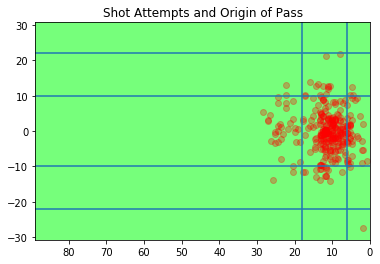

In [142]:
fig, ax = plt.subplots()
ax.scatter(shots_df[shots_df['is_goal']==1]['shot_coord_x1'], shots_df[shots_df['is_goal']==1]['shot_coord_y1'], alpha=0.3, color='red')
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('Shot Attempts and Origin of Pass')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

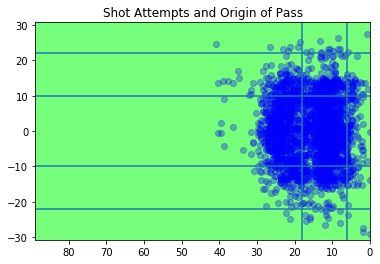

In [143]:
fig, ax = plt.subplots()
ax.scatter(shots_df['shot_coord_x1'], shots_df['shot_coord_y1'], alpha=0.3, color='blue')
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('Shot Attempts and Origin of Pass')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

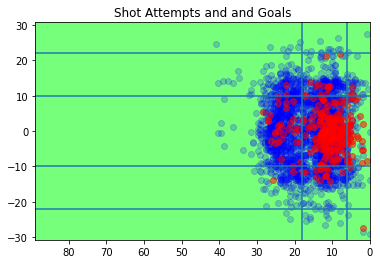

In [209]:
fig, ax = plt.subplots()
ax.scatter(shots_df[shots_df['is_goal']==0]['shot_coord_x1'], shots_df[shots_df['is_goal']==0]['shot_coord_y1'], alpha=0.2, color='blue')
ax.scatter(shots_df[shots_df['is_goal']==1]['shot_coord_x1'], shots_df[shots_df['is_goal']==1]['shot_coord_y1'], alpha=0.5, color='red')

# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('Shot Attempts and and Goals')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

In [147]:
train_data.head()

,player_id,shot_distance,shot_angle,assisted_shot,is_penalty_attempt
13,68605.0,15.852271,11.019309,0,0
14,26050.0,21.339363,-33.570919,0,0
15,8907.0,15.677426,-42.492487,1,0
16,172565.0,9.350166,31.173938,1,0
17,37152.0,12.877985,14.985870,1,0


In [148]:
shots_df.head()

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,team_id,time_of_event(min),passed_from_id,pass_coord_x1,pass_coord_x2,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal
0,448548,99779.0,6.67,0.00,1.51,-1.21,-1,0.83,22336297,11,20,1.033333,177285.0,0.89,12.44,29.36,-4.84,-1.0,-1.0,1.0,6.838786,12.755990,1,0,1.0
1,448548,60730.0,21.33,12.00,4.24,-0.91,-1,0.73,22336386,35,20,9.683333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.747333,11.242763,0,0,0.0
2,448548,177285.0,12.00,1.78,0.00,-3.03,-1,0.21,22336583,13,20,26.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.000000,0.000000,0,1,1.0
3,448548,185745.0,8.44,0.89,14.53,-6.66,-1,-1.00,22336723,33,20,38.883333,177285.0,22.67,6.22,3.93,19.67,-1.0,-1.0,0.0,16.803407,59.849102,1,0,0.0
4,448548,77892.0,22.22,0.44,13.92,-8.48,-1,-1.00,22336739,33,13,40.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,26.220122,32.065607,0,0,0.0


In [203]:
from create_shot_coordinates import coord_table, distance_pred

In [204]:
six_yard_shot = coord_table(-10, 10, 2, 2, 6, 2)

In [210]:
six_yard_shot.head()

,shot_coord_x1,shot_coord_y1,assisted_shot,is_penalty_attempt,shot_distance,shot_angle
0,2,-10,0,0,10.198039,-78.690068
1,2,-8,0,0,8.246211,-75.963757
2,2,-6,0,0,6.324555,-71.565051
3,2,-4,0,0,4.472136,-63.434949
4,2,-2,0,0,2.828427,-45.000000


In [206]:
example = distance_pred(six_yard_shot, 979779.0)

In [208]:
example.head()

,assisted_shot,is_penalty_attempt,shot_distance,shot_angle,player_id
0,0,0,10.198039,-78.690068,979779.0
1,0,0,8.246211,-75.963757,979779.0
2,0,0,6.324555,-71.565051,979779.0
3,0,0,4.472136,-63.434949,979779.0
4,0,0,2.828427,-45.000000,979779.0


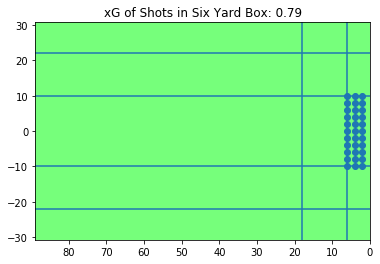

In [223]:
fig, ax = plt.subplots()
ax.scatter(six_yard_shot['shot_coord_x1'], six_yard_shot['shot_coord_y1'])
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('xG of Shots in Six Yard Box: 0.79')

ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

In [214]:
six_rf_pred = random_forest_model.predict_proba(example)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [222]:
six_rf_pred.sum(axis=0)[1] / len(six_rf_pred)

0.7955235743889505

In [219]:
len(six_rf_pred)

33

# Example of creating visual

In [224]:
eighteen_yard_shot = coord_table(-10, 10, 2, 8, 18, 2)

In [225]:
example2 = distance_pred(eighteen_yard_shot, 979779.0)

In [226]:
eighteen_rf_pred = random_forest_model.predict_proba(example2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


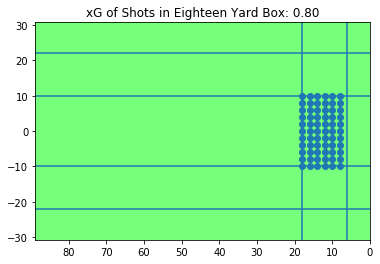

In [228]:
fig, ax = plt.subplots()
ax.scatter(eighteen_yard_shot['shot_coord_x1'], eighteen_yard_shot['shot_coord_y1'])
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('xG of Shots in Eighteen Yard Box: 0.80')

ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

In [227]:
eighteen_rf_pred.sum(axis=0)[1] / len(eighteen_rf_pred)

0.8030485631465777

In [235]:
beyond_eighteen_yard_shot = coord_table(-22, 22, 2, 20, 30, 2)

In [236]:
example3 = distance_pred(beyond_eighteen_yard_shot, 979779.0)

In [237]:
beyond_eighteen_rf_pred = random_forest_model.predict_proba(example3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.2s finished


In [238]:
beyond_eighteen_rf_pred.sum(axis=0)[1] / len(beyond_eighteen_rf_pred)

0.7945974953938425

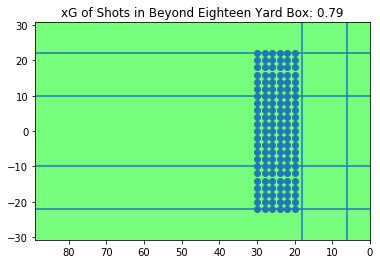

In [239]:
fig, ax = plt.subplots()
ax.scatter(beyond_eighteen_yard_shot['shot_coord_x1'], beyond_eighteen_yard_shot['shot_coord_y1'])
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('xG of Shots in Beyond Eighteen Yard Box: 0.79')

ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

In [242]:
player2_example = distance_pred(six_yard_shot, 39414.0)
player2_example2 = distance_pred(eighteen_yard_shot, 39414.0)
player2_example3 = distance_pred(beyond_eighteen_yard_shot, 39414.0)

In [243]:
six_pred1 = random_forest_model.predict_proba(player2_example)
eighteen_pred1 = random_forest_model.predict_proba(player2_example2)
beyond_eighteen_pred1 = random_forest_model.predict_proba(player2_example3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [ ]:
print(six_rf_pred.sum(axis=0)[1] / len(six_rf_pred))
print(eighteen_rf_pred.sum(axis=0)[1] / len(eighteen_rf_pred))
